### LITTLE EYES V3
#### Meu Terceiro Modelo de Visão Computacional

Validação cruzada / controle de parada para selecionar o modelo mais genérico 

In [1]:
# NETWORK
the_seed = 32
digit_size = (28, 28, 1)
convnn_activation = 'relu'
fully_connected_activation = 'tanh'
hyperparameter_max = 5
learning_rate = 0.01
max_epochs = 5
score_metric = 'accuracy'
verbose = 1

# VALIDATION
n_folds = 5

In [2]:
import tensorflow
from tensorflow.keras import datasets, models, layers, optimizers, Input, Model
from matplotlib import pyplot
import numpy
import pandas
import random
from sklearn.model_selection import StratifiedKFold
from seaborn import boxplot
from sklearn.metrics import accuracy_score

In [3]:
random.seed(the_seed)
numpy.random.seed(the_seed)
tensorflow.random.set_seed(the_seed)

In [4]:
def create_little_eyes(digit_size : tuple[int, int, int] = (28, 28, 1),
                       convnn_activation : str = 'relu',
                       fully_connected_activation : str = 'tanh',
                       net_name : str = 'LittleEyes',
                       hyperparameter : int = 1):
    # CAMADA DE ENTRADA
    inputs = Input(shape=digit_size)

    # PRIMEIRA CAMADA CONVOLUCIONAL
    conv_2d_layer_1 = layers.Conv2D(2*hyperparameter, (3, 3), activation=convnn_activation)
    x = conv_2d_layer_1(inputs)

    # PRIMEIRA CAMADA MAX POOLING
    maxpool_1 = layers.MaxPooling2D((2, 2))
    x = maxpool_1(x)

    # SEGUNDA CAMADA CONVOLUCIONAL
    conv_2d_layer_2 = layers.Conv2D(4*hyperparameter, (3, 3), activation=convnn_activation)
    x = conv_2d_layer_2(x)

    # SEGUNDA CAMADA MAX POOLING
    maxpool_2 = layers.MaxPooling2D((2, 2))
    x = maxpool_2(x)

    # TERCEIRA CAMADA CONVOLUCIONAL
    conv_2d_layer_3 = layers.Conv2D(4*hyperparameter, (3, 3), activation=convnn_activation)
    x = conv_2d_layer_3(x)

    # TERCEIRA CAMADA MAX POOLING
    maxpool_3 = layers.MaxPooling2D((2, 2))
    x = maxpool_3(x)

    # FLATTEN
    flatten_layer = layers.Flatten()
    x = flatten_layer(x)

    # FULLY CONNECTED HIDDEN LAYER
    hidden_layer = layers.Dense(hyperparameter + 1, activation=fully_connected_activation)
    x = hidden_layer(x)

    # OUTPUT LAYER
    output_layer = layers.Dense(10)
    outputs = output_layer(x)

    return Model(inputs=inputs, outputs=outputs, name=net_name)

In [5]:
(train_images, train_labels), (validation_images, validation_labels) = datasets.mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, validation_images = train_images / 255.0, validation_images / 255.0

11490434/11490434 [==============================] - 2s 0us/step


In [6]:
train_images.shape, validation_images.shape

((60000, 28, 28), (10000, 28, 28))

In [7]:
numpy.unique(train_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
       dtype=int64))

In [8]:
result_list = []
kfolder = StratifiedKFold(n_splits=n_folds, random_state=the_seed, shuffle=True)
for hyperparameter in numpy.arange(1, hyperparameter_max+1):
    for i, (train_index, validation_index) in enumerate(kfolder.split(train_images, train_labels)):
        X_train, Y_train = train_images[train_index], train_labels[train_index]
        X_val, Y_val = train_images[validation_index], train_labels[validation_index]

        # NET NAME > Hyperparameter + Fold Number
        net_name = f"LittleEyes_{hyperparameter}_{i}"
        print(f"{net_name} training started...")
        little_eyes = create_little_eyes(net_name = net_name,
                                        hyperparameter=hyperparameter)
        opt = optimizers.Adam(learning_rate=learning_rate)
        little_eyes.compile(optimizer=opt,
                    loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=[score_metric])

        history = little_eyes.fit(X_train, Y_train, epochs=max_epochs, 
                                validation_data=(X_val, Y_val),
                                verbose=verbose)

        training_score = history.history[score_metric][-1]
        validation_score = history.history[f"val_{score_metric}"][-1]
        result_list.append((net_name, hyperparameter, i, training_score, validation_score, little_eyes))
        print(f"{net_name.upper()}: {100*training_score:.0f}% TRAINING {score_metric.upper()} / {100*validation_score:.0f}% VALIDATION {score_metric.upper()}")
        

LittleEyes_1_0 training started...
Epoch 1/5
1500/1500 [==============================] - 11s 6ms/step - loss: 1.3826 - accuracy: 0.4439 - val_loss: 1.1864 - val_accuracy: 0.5745
Epoch 2/5
1500/1500 [==============================] - 9s 6ms/step - loss: 1.1190 - accuracy: 0.5994 - val_loss: 1.0584 - val_accuracy: 0.6296
Epoch 3/5
1500/1500 [==============================] - 9s 6ms/step - loss: 1.0254 - accuracy: 0.6405 - val_loss: 1.0508 - val_accuracy: 0.6075
Epoch 4/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.9927 - accuracy: 0.6560 - val_loss: 0.9514 - val_accuracy: 0.6726
Epoch 5/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.9657 - accuracy: 0.6695 - val_loss: 0.9680 - val_accuracy: 0.6670
LITTLEEYES_1_0: 67% TRAINING ACCURACY / 67% VALIDATION ACCURACY
LittleEyes_1_1 training started...
Epoch 1/5
1500/1500 [==============================] - 10s 6ms/step - loss: 1.5454 - accuracy: 0.3859 - val_loss: 1.1666 - val_accuracy: 0.5523
Epoch 

In [9]:
results = pandas.DataFrame.from_records(result_list)
results.columns = ["net_name", "hyperparameter", "kfold", score_metric, f"val_{score_metric}", "little_eyes"]
results.sort_values("val_accuracy", ascending=False)

,net_name,hyperparameter,kfold,accuracy,val_accuracy,little_eyes
24,LittleEyes_5_4,5,4,0.952146,0.955250,<keras.src.engine.functional.Functional object...
15,LittleEyes_4_0,4,0,0.952521,0.955167,<keras.src.engine.functional.Functional object...
19,LittleEyes_4_4,4,4,0.948458,0.949333,<keras.src.engine.functional.Functional object...
17,LittleEyes_4_2,4,2,0.952333,0.948250,<keras.src.engine.functional.Functional object...
16,LittleEyes_4_1,4,1,0.956708,0.946083,<keras.src.engine.functional.Functional object...
21,LittleEyes_5_1,5,1,0.950521,0.941333,<keras.src.engine.functional.Functional object...
12,LittleEyes_3_2,3,2,0.943563,0.939583,<keras.src.engine.functional.Functional object...
22,LittleEyes_5_2,5,2,0.949021,0.936167,<keras.src.engine.functional.Functional object...
14,LittleEyes_3_4,3,4,0.948208,0.934333,<keras.src.engine.functional.Functional object...
11,LittleEyes_3_1,3,1,0.934375,0.932917,<keras.src.engine.functional.Functional object...


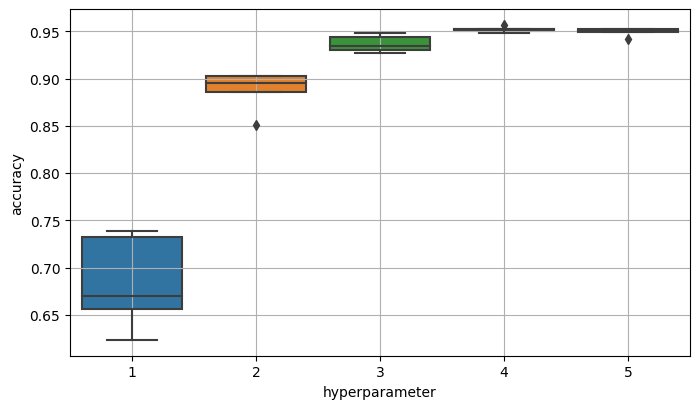

In [10]:
fig = pyplot.figure(figsize=(8, 4.5))
ax = fig.add_subplot(111)
boxplot(results, x="hyperparameter", y="accuracy", ax=ax)
ax.grid()

In [11]:
little_eyes = results.sort_values('val_accuracy', ascending=False).head(1)['little_eyes'].values[0]
little_eyes

In [12]:
Y_test = little_eyes.predict(validation_images)

313/313 [==============================] - 1s 3ms/step


In [13]:
Y_predicted = numpy.argmax(Y_test, axis=1)
Y_predicted

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [31]:
# find where the predicted labels are different from the true labels
wrong_index = numpy.where(Y_predicted != validation_labels)[0]
wrong_index

array([  18,   62,   73,   97,  111,  115,  124,  217,  242,  247,  255,
        266,  282,  320,  362,  411,  445,  468,  482,  511,  524,  528,
        571,  593,  624,  646,  659,  674,  679,  684,  692,  694,  707,
        717,  720,  726,  740,  813,  817,  829,  844,  853,  882,  926,
        938,  939,  946,  947,  965,  969, 1012, 1014, 1032, 1050, 1062,
       1112, 1114, 1119, 1122, 1178, 1224, 1226, 1242, 1256, 1260, 1281,
       1299, 1326, 1328, 1337, 1378, 1393, 1425, 1453, 1465, 1494, 1500,
       1549, 1569, 1627, 1634, 1678, 1709, 1717, 1754, 1790, 1847, 1865,
       1900, 1901, 1940, 1941, 1989, 1992, 2009, 2035, 2043, 2053, 2070,
       2090, 2095, 2115, 2129, 2130, 2135, 2143, 2148, 2182, 2186, 2189,
       2225, 2237, 2238, 2280, 2291, 2293, 2300, 2314, 2329, 2369, 2380,
       2394, 2406, 2414, 2433, 2447, 2454, 2462, 2466, 2488, 2532, 2573,
       2574, 2578, 2582, 2597, 2607, 2654, 2665, 2686, 2695, 2720, 2749,
       2754, 2770, 2771, 2778, 2843, 2850, 2851, 28

TRUE NUMBER 7 >> PREDICTED NUMBER 4


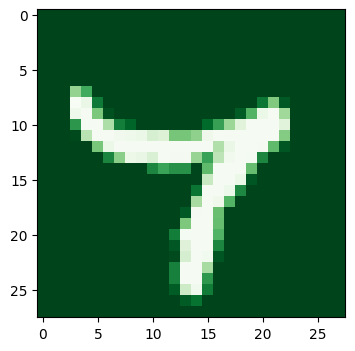

In [42]:
# TABAJARA VALIDATOR
image_id = 124
print(f"TRUE NUMBER {validation_labels[image_id]} >> PREDICTED NUMBER {Y_predicted[image_id]}")
# Y_test[image_id, :]
fig = pyplot.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
_ = pyplot.imshow(validation_images[image_id], cmap="Greens_r")

In [35]:
accuracy_score(validation_labels, Y_predicted)

0.9559